In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
%matplotlib inline
import os
import random
import gc
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [2]:
#test 20% train 80%
train_dir = '../input/galaxydata/train'
test_dir = '../input/galaxydata/test'

#get spiral images
train_spiral = ['../input/galaxydata/train/{}'.format(i) for i in os.listdir(train_dir) if 'spiral' in i]
#get edge images
train_edge = ['../input/galaxydata/train/{}'.format(i) for i in os.listdir(train_dir) if 'edge' in i]

#get test images
test_imgs = ['../input/galaxydata/test/{}'.format(i) for i in os.listdir(test_dir)]

#partition dataset to only use 2000 in each class
train_imgs = train_spiral[:2000] + train_edge[:2000]
random.shuffle(train_imgs)

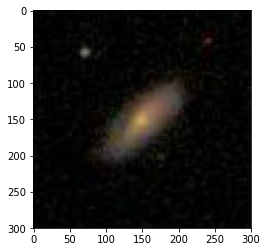

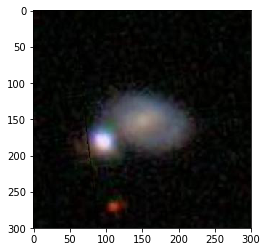

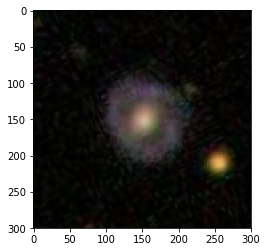

In [3]:
#show 3 images
for ima in train_imgs[0:3]:
    image = mpimg.imread(ima)
    imgplot = plt.imshow(image)
    plt.show()

In [4]:
#set image pixel size to be 300x300 instead of 424x424
nrows = 300
ncolumns = 300
channels = 3

In [5]:
#format images to read and process for model
def process_image(list_of_images):
    x = [] #images
    y = [] #labels
    for image in list_of_images:
        #read the image
        x.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation = cv2.INTER_CUBIC))
        #get labels
        if 'spiral' in image:
            y.append(1)
        elif 'edge' in image:
            y.append(0)
    return x,y

In [6]:
x, y = process_image(train_imgs)

In [7]:
#view 1st image's arrays of pixel values
x[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 1, 2],
        [0, 0, 4],
        [0, 0, 4]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 1, 2],
        [0, 0, 4],
        [0, 0, 4]],

       [[0, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 1, 2],
        [0, 0, 4],
        [0, 0, 4]],

       ...,

       [[0, 0, 0],
        [0, 1, 1],
        [0, 2, 2],
        ...,
        [4, 6, 6],
        [0, 2, 2],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 1, 1],
        [0, 2, 2],
        ...,
        [4, 6, 6],
        [0, 2, 2],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 1, 1],
        [0, 2, 2],
        ...,
        [4, 6, 6],
        [0, 2, 2],
        [0, 0, 0]]], dtype=uint8)

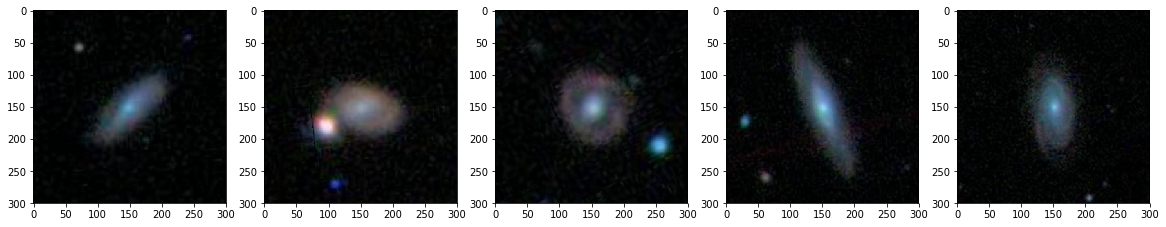

In [8]:
#plot first 5 arrays of x
plt.figure(figsize = (20,10))
columns = 5
for i in range(columns):
    plt.subplot(5/columns + 1, columns, i +1)
    plt.imshow(x[i])

In [9]:
#convert to numpy array
x = np.array(x)
y = np.array(y)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.20, random_state = 2)

#affirm shape of data
print("Shape of train images is:", x_train.shape)
print("Shape of validation images is:", x_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (3200, 300, 300, 3)
Shape of validation images is: (800, 300, 300, 3)
Shape of labels is: (3200,)
Shape of labels is: (800,)


In [11]:
#finds length of train/validation data
ntrain = len(x_train)
nval = len(x_val)
batch_size = 32

In [12]:
#run model with layers
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (300, 300, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten()) #flatten layer
model.add(layers.Dropout(0.5)) #dropout for regularization (can adjust) helps to not overfit
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1,activation = 'sigmoid')) #only 2 classes

In [13]:
model.summary() # of layers and parameters

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 128)       147584    
__________

In [14]:
#RMSprop optimizer with a learning rate of 0.0001 for hyperparametric tuning
#binary_crossentropy loss because of binary classification
#for compiling the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [15]:
#imageDataGenerator to normalize
#create augmentation configuration
#works against overfitting
train_datagen = ImageDataGenerator(rescale = 1./225, #normalizes the image pixel values to have zero mean and standard deviation of 1
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,)
val_datagen = ImageDataGenerator(rescale=1./225) #helps model generally learn and update its parameters efficiently
#only performs a rescale

In [16]:
#create image generators
train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size = batch_size)

In [17]:
#training data
#100 steps per epoch (30 epochs)
history = model.fit_generator(train_generator,
                             steps_per_epoch = ntrain // batch_size,
                             epochs = 30,
                             validation_data = val_generator,
                             validation_steps = nval // batch_size)

Epoch 1/30
100/100 [==============================] - 65s 653ms/step - loss: 0.5896 - acc: 0.6912 - val_loss: 0.8114 - val_acc: 0.5950
Epoch 2/30
100/100 [==============================] - 63s 633ms/step - loss: 0.4635 - acc: 0.7791 - val_loss: 0.3979 - val_acc: 0.8125
Epoch 3/30
100/100 [==============================] - 63s 630ms/step - loss: 0.4081 - acc: 0.8172 - val_loss: 0.3206 - val_acc: 0.8662
Epoch 4/30
100/100 [==============================] - 63s 632ms/step - loss: 0.3728 - acc: 0.8331 - val_loss: 0.3466 - val_acc: 0.8562
Epoch 5/30
100/100 [==============================] - 63s 626ms/step - loss: 0.3654 - acc: 0.8384 - val_loss: 0.3432 - val_acc: 0.8413
Epoch 6/30
100/100 [==============================] - 63s 625ms/step - loss: 0.3455 - acc: 0.8425 - val_loss: 0.2704 - val_acc: 0.8988
Epoch 7/30
100/100 [==============================] - 63s 628ms/step - loss: 0.3379 - acc: 0.8519 - val_loss: 0.2582 - val_acc: 0.9025
Epoch 8/30
100/100 [==============================] - 6

In [18]:
#save the model
model.save_weights('model_weight.h5')
model.save('model_keras.h5')

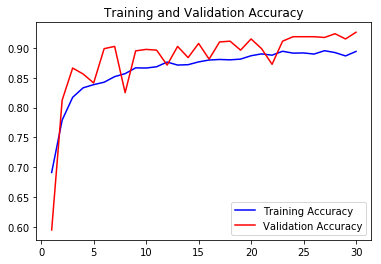

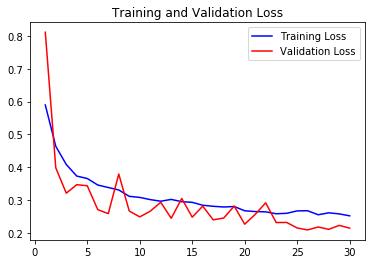

In [19]:
#Plot the train and val curve
#get details from the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

#train and validation accuracy
plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
#train and validation loss
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [20]:
#predict the first 10 images on the test set
x_test, y_test = process_image(test_imgs[0:10])
#Y_test in this case will be empty
x = np.array(x_test)
test_datagen = ImageDataGenerator(rescale = 1./225)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


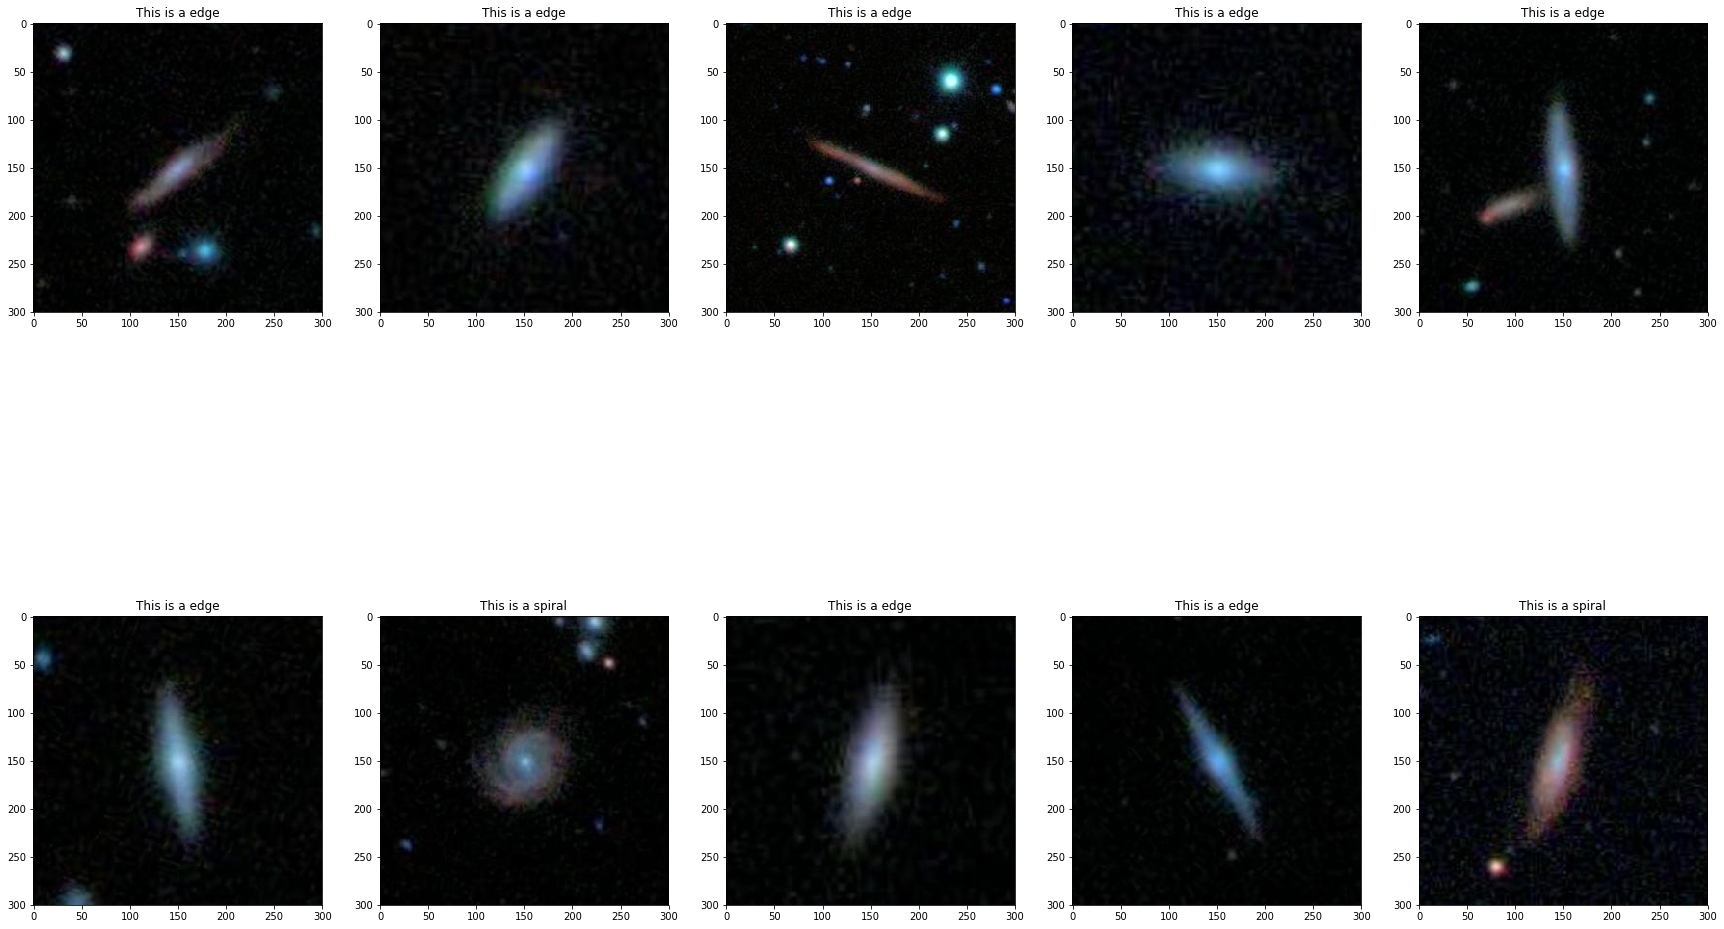

In [21]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x,batch_size = 1):
    pred = model.predict(batch)
    if pred > 0.5: 
        text_labels.append('spiral')
    else:
        text_labels.append('edge')
    plt.subplot(5/columns + 1, columns, i+1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1 
    if i % 10 == 0:
        break
plt.show()